# Sentiment Analysis in Python

### import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer as TfIdf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import *

import torch
# from transformers import BertModel, BertTokenizer
# from torch.utils.data import DataLoader

import pickle

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### import dataset

In [3]:
data = pd.read_csv("Dataset-SA.csv")
data.head(1)

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive


### Clean and modify dataset

In [4]:
data = data[["Summary", "Sentiment"]]
data.head(5)

,Summary,Sentiment
0,great cooler excellent air flow and for this p...,positive
1,best budget 2 fit cooler nice cooling,positive
2,the quality is good but the power of air is de...,positive
3,very bad product its a only a fan,negative
4,ok ok product,neutral


In [5]:
data.shape

(205052, 2)

In [6]:
data = data.dropna()
data.isna().sum()

Summary      0
Sentiment    0
dtype: int64

In [7]:
data = data.drop_duplicates()
data.duplicated().sum()

np.int64(0)

In [8]:
data = data.reset_index(drop=True)
data.shape

(93921, 2)

In [9]:
data.value_counts("Sentiment")

Sentiment
positive    69342
negative    18789
neutral      5790
Name: count, dtype: int64

In [10]:
df = data.copy()

In [11]:
df.Sentiment = df["Sentiment"].astype("category").cat.codes
df.head()

,Summary,Sentiment
0,great cooler excellent air flow and for this p...,2
1,best budget 2 fit cooler nice cooling,2
2,the quality is good but the power of air is de...,2
3,very bad product its a only a fan,0
4,ok ok product,1


### EDA

* 0: Negative
* 1: Neutral
* 2: Positive

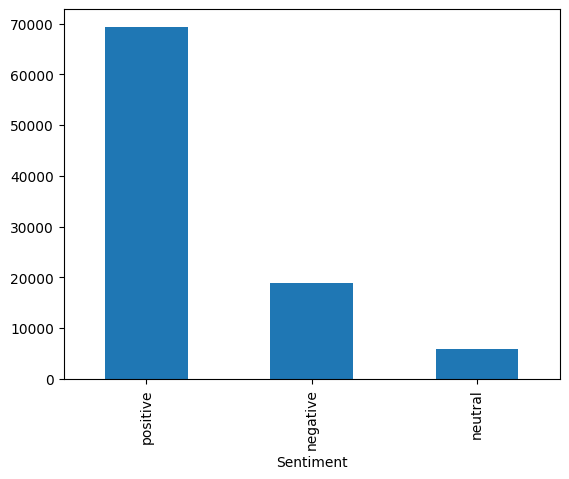

In [12]:
data["Sentiment"].value_counts().plot(kind="bar")
plt.show()

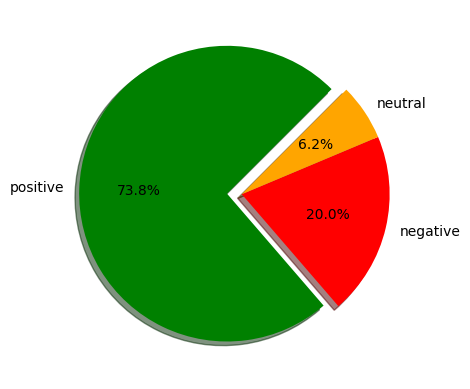

In [13]:
color = ["Green", "Red", "Orange"]
data["Sentiment"].value_counts().plot(kind="pie", autopct='%.1f%%', shadow=True, 
                                      colors=color, explode=(0.1, 0, 0), startangle=45)
plt.ylabel(None)
plt.show()

### Clean Text

In [14]:
df["Summary"][0]

'great cooler excellent air flow and for this price its so amazing and unbelievablejust love it'

* remove html tags
* extract emojies
* remove special char
* convert lower text
* remove stopwords
* tokenization

In [15]:
# nltk.download('stopwords') # if not available
stop_word = set(stopwords.words("english"))
emoji_pattern = re.compile(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)')

In [16]:
def preprocessing(text):
    text = re.sub(r'<[^>]*>', '', text) # remove html tags
    emojis = emoji_pattern.findall(text)
    text = re.sub(r'[\W+]', ' ', text.lower()) + ' '.join(emojis).replace('-', '')

    peter = PorterStemmer()
    text = [peter.stem(word) for word in text.split() if word not in stop_word]

    return " ".join(text)

In [17]:
df["Summary"] = df["Summary"].apply(lambda x: preprocessing(x))
df["Summary"].head()

0    great cooler excel air flow price amaz unbelie...
1                   best budget 2 fit cooler nice cool
2                        qualiti good power air decent
3                                      bad product fan
4                                        ok ok product
Name: Summary, dtype: object

### visualizing top10 words Sentimint wise

In [18]:
positive_data = df[df['Sentiment'] == 2]
positive_data = positive_data["Summary"]

natural_data = df[df['Sentiment'] == 1]
natural_data = natural_data["Summary"]

negative_data = df[df['Sentiment'] == 0]
negative_data = negative_data["Summary"]

In [19]:
positive_data_words = ' '.join(positive_data).split()
positive_data_words_count = Counter(positive_data_words)
positive_data_common_words = positive_data_words_count.most_common(10)

natural_data_words = ' '.join(natural_data).split()
natural_data_words_count = Counter(natural_data_words)
natural_data_common_words = natural_data_words_count.most_common(10)

negative_data_words = ' '.join(negative_data).split()
negative_data_words_count = Counter(negative_data_words)
negative_data_common_words = negative_data_words_count.most_common(10)

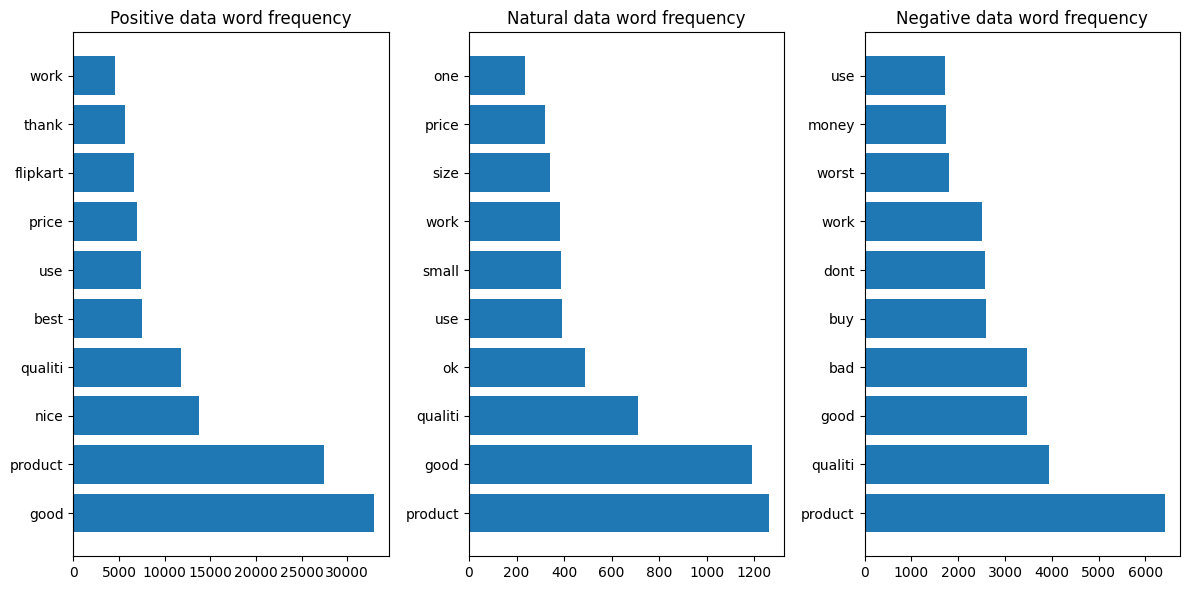

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12,6))

ax[0].barh(range(len(positive_data_common_words)), 
           [count for _, count in positive_data_common_words],
           align='center')
ax[0].set_yticks(range(len(positive_data_common_words)))
ax[0].set_yticklabels([word for word, _ in positive_data_common_words])
ax[0].set_title('Positive data word frequency')

ax[1].barh(range(len(natural_data_common_words)), 
           [count for _, count in natural_data_common_words],
           align='center')
ax[1].set_yticks(range(len(natural_data_common_words)))
ax[1].set_yticklabels([word for word, _ in natural_data_common_words])
ax[1].set_title('Natural data word frequency')

ax[2].barh(range(len(negative_data_common_words)), 
           [count for _, count in negative_data_common_words],
           align='center')
ax[2].set_yticks(range(len(negative_data_common_words)))
ax[2].set_yticklabels([word for word, _ in negative_data_common_words])
ax[2].set_title('Negative data word frequency')

plt.tight_layout()
plt.show()

### Vectorizer using TF-IDF 

In [21]:
tfidf = TfIdf(strip_accents=None, lowercase=False, preprocessor=None, use_idf=True, norm='l2', smooth_idf=True) # smooth_idf give importants for rare words
y = df["Sentiment"].values
x = tfidf.fit_transform(df["Summary"])

### Vectorizer using BERT

In [22]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

In [23]:
# sentences = df["Summary"].tolist()
# data_loader = DataLoader(sentences, batch_size=32, shuffle=False)

In [24]:
# encoding for sentences
# def get_encoding(batch):
#     inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)

#     with torch.no_grad():
#         outputs = model(**inputs)

#     embendings = outputs.last_hidden_state.mean(dim=1)
#     return embendings

In [25]:
# all_embeddings = []

# # Iterate through batches in the DataLoader
# for batch in data_loader:
#     embeddings = get_encoding(batch)
#     all_embeddings.append(embeddings)

In [26]:
# x_tf = torch.cat(all_embeddings, dim=0) # Concatenate embeddings from all batches
# x = x_tf.cpu().detach().numpy() # using bert embending within classical ML

# y = df["Sentiment"].values

### ML model

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [28]:
clf_model = LogisticRegressionCV(cv=6, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=500)

In [29]:
clf_model.fit(x_train, y_train)
y_pred = clf_model.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   18.2s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   18.8s finished


In [30]:
# Accuracy check
print(f"Accuracy: {accuracy_score(y_pred, y_test)*100:.2f}%")

Accuracy: 86.30%


### Check Model using Prediction

In [31]:
def check_model(review):
    clean_review = preprocessing(review)
    review_list = [clean_review]
    review_vector = tfidf.transform(review_list)
    prediction = clf_model.predict(review_vector)[0]

    if prediction == 0:
        return "Negative Review"
    elif prediction == 1:
        return "Natural Review"
    elif prediction == 2:
        return "Positive Review"

In [32]:
review_list1 = [
    "🔴Don't buy this. Lock code automatically changes after using code to lock for once. Can't open the suitcase with same lock code again. Had to open by using some tricks. The lock changes to new code every time we use. Not recommended at all. ❌",
    "The manufacturer should have been fitted a good quality number lock in this trolley bag.",
    "Product is okok. It is not strong. Build quality is low. But at this price it is cheaper, that's why I don't return it.",
    "The quality is very nice .. I would give it a 10/10 And storage of the bag is okay as it is a medium sized trolley and all over the colour of the trolley makes you look more classy .... It was a great experience purchasing from Flipkart ☺️☺️",
    "The suitcase is locked again and again trying multiple times with a pin but it is not working.",
    "Expection is high but reality is😥😭😥😭😭😭😭👎👎👎👎👎👎👎👎👎👎"
]

for review in review_list1:
    prediction = check_model(review)
    print(prediction)

Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review


In [33]:
review_list2 = [
    "Really amazing product but not for high bass lover, normal bass is good, design is just wow",
    "poor sound and to much lack sound, poor call experience no Recommand for purchase",
    "Sound quality Good 👍",
    "Waste of money. Dears please don't buy this product. 🤮🤮🤬",
    "Very bad product... Voice quality is chief... Don't take every body.",
    "Ear feting not properly"
]

for review in review_list2:
    prediction = check_model(review)
    print(prediction)

Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review


### Download Pickle File

In [ ]:
pickle.dump(clf_model, open('clf_model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))